<a href="https://colab.research.google.com/github/eduardarsimoes/lae1/blob/main/Titanic/Titanic_Sprint3_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATASET TITANIC**
---
### **LAB. EXTENSÃO 2020/2 EAD** - Eduarda Simões, Serenna Ferrari e Thaís de Souza

### Importando bibliotecas e respectivos módulos

In [ ]:
import sys

!"{sys.executable}" -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# Importando bibliotecas
import sklearn as skl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from pandas_profiling import ProfileReport
from sklearn import preprocessing
%matplotlib inline

### Carregando dataset e resumo de dados

---



In [ ]:
url = "https://raw.githubusercontent.com/profmoisesomena/escience_and_tools/master/data/titanic_dados_t.csv"

#RENOMEOU-SE ALGUNS ATRIBUTOS
names = ["PassengerId","survived","shipClass","name","sex","age","siblingsSpousesOnboard","parentsChildrenOnboard","ticket","fareTicket","cabin","embarkedHarbor"]
dataset = pd.read_csv(url, header=0, names=names)

pd.pandas.set_option('display.max_columns', None)
#print(dataset.head())


### Pré processamento

In [ ]:
#GERANDO O PROFILING REPORT (EDA)
profile = ProfileReport(
    dataset, title="Titanic Dataset", html={"style": {"full_width": True}}, sort="None",
    correlations={"cramers": {"calculate": False}}) 
profile.to_file('titanic_raw.html')

In [ ]:
profile.to_notebook_iframe()

In [ ]:
#VERIFICANDO DADOS DUPLICADOS
sum(dataset.duplicated())

0

In [ ]:
#REMOVENDO ATRIBUTOS IRRELEVANTES
dataset.drop(["PassengerId","name","ticket","cabin","embarkedHarbor"], axis = 1, inplace = True) #axis = 1 (toda coluna) | inplace = True (replace)
#print(dataset.head())

In [ ]:
#VERIFICANDO DADOS DUPLICADOS
sum(dataset.duplicated())

114

In [ ]:
#VERIFICANDO OS DADOS NULOS E TIPO
dataset_analise_nulos = dataset
stat_data = dataset_analise_nulos.describe().T #T = transpose
stat_data['nulos'] = pd.DataFrame(dataset_analise_nulos.isnull().sum())
stat_data['percentualNulos'] = pd.DataFrame(dataset_analise_nulos.isna().mean().round(4)*100)
stat_data['type'] = pd.Series(dataset_analise_nulos.dtypes)
#stat_data


In [ ]:
# PREENCHENDO OS VALORES NULOS DE IDADE COM BASE NA MEDIA
age_media = dataset.age.mean()
dataset.fillna(age_media, inplace = True)

In [ ]:
#VERIFICANDO OS VALORES NULOS TRATADOS ANTERIORMENTE
dataset.isnull().sum()

survived                  0
shipClass                 0
sex                       0
age                       0
siblingsSpousesOnboard    0
parentsChildrenOnboard    0
fareTicket                0
dtype: int64

In [ ]:
#CONVERTENDO OS VALORES DO ATRIBUTO 'SEX' - female, male PARA 0, 1
label_encoder = preprocessing.LabelEncoder()
dataset['sex']= label_encoder.fit_transform(dataset['sex'])

In [ ]:
#ENCAIXOTANDO (BINNING) PREÇOS DAS TARIFAS
valuesFare = dataset.fareTicket
groups_names = [1, 2, 3, 4, 5]
categories = pd.qcut(valuesFare, 5, labels=groups_names)
pd.value_counts(categories)
dataset['categories_fareTicket'] = categories
dataset.drop("fareTicket", axis = 1, inplace = True)
dataset.head()

,survived,shipClass,sex,age,siblingsSpousesOnboard,parentsChildrenOnboard,categories_fareTicket
0,0,3,1,22.0,1,0,1
1,1,1,0,38.0,1,0,5
2,1,3,0,26.0,0,0,2
3,1,1,0,35.0,1,0,5
4,0,3,1,35.0,0,0,2


In [ ]:
dataset.shape

(891, 7)

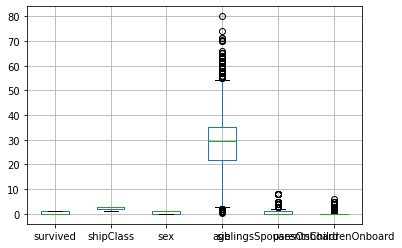

In [ ]:
 #EXCLUINDO OUTLIERS
dataset_summary = dataset.iloc[:,:-1]
q1 = dataset_summary.quantile(0.25)
q3 = dataset_summary.quantile(0.75)
IQR = q3 - q1
lowqe_bound = q1 - 3 * IQR
upper_bound = q3 + 3 * IQR
dataset_summary.boxplot()

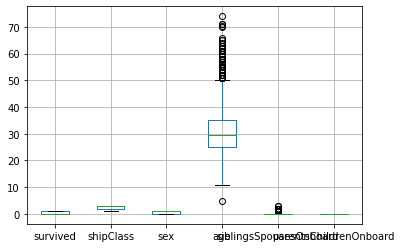

In [ ]:
IQR_dataset = dataset_summary[~((dataset_summary < lowqe_bound) | (dataset_summary > upper_bound)).any(axis=1)]
IQR_dataset.boxplot()

In [ ]:
IQR_dataset.shape

(677, 6)

In [ ]:
#BALANCEAMENTO = VERIFICANDO VARIAÇÃO NO ATRIBUTO ALVO
target = "survived"
count_class_0, count_class_1 = dataset[target].value_counts()
print(count_class_0)
print(count_class_1)

549
342


In [ ]:
# Profiling Report
profile = ProfileReport(dataset, html={"style": {"full_width": True}}, sort="None")
profile.to_file("titanic_done.html")

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_notebook_iframe()

### Separando conjuntos de dados para treinamento e teste

In [ ]:
array = IQR_dataset.values 
x, y = array[:, 1:], array[:,0]

In [ ]:
x_train, x_teste, y_train, y_teste = train_test_split(x, y, test_size = 0.25, random_state = 0, shuffle = True)

### Criando modelo

In [ ]:
model = LogisticRegression() #CLASSIFICACAO
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Acurácia

In [ ]:
print("\n --- Precisão de treino --- \n ==> ", skl.metrics.accuracy_score(y_train, model.predict(x_train)))
print("\n --- Precisão de teste ---\n ==>", skl.metrics.accuracy_score(y_teste, model.predict(x_teste)))


 --- Precisão de treino --- 
 ==>  0.8165680473372781

 --- Precisão de teste ---
 ==> 0.8411764705882353


## **Métricas**

### Separando conjuntos de dados para treinamento e teste

In [ ]:
array = dataset.values 
x, y = array[:, 1:], array[:,0]

In [ ]:
test_size = 0.20
x_train_d, x_teste_d, y_train_d,y_teste_d = model_selection.train_test_split(x, y, test_size = test_size, random_state = 5)

### Criando modelo

In [ ]:
model = LogisticRegression(random_state = 0, max_iter = 1000, C = 1).fit(x, y)
model.fit(x_train_d, y_train_d)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Obtendo predict

In [ ]:
predicted_d = model.predict(x_teste_d)

### Matriz de confusão

In [ ]:
matrix = confusion_matrix(y_teste_d, predicted_d)

print('==== Conf. Matrix ====')
print(matrix)

report = classification_report(y_teste_d, predicted_d)
print('\n==== Report ====')
print(report)

==== Conf. Matrix ====
[[98 13]
 [18 50]]

==== Report ====
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       111
         1.0       0.79      0.74      0.76        68

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



In [ ]:
pd.crosstab(y_teste_d, predicted_d)

col_0,0.0,1.0
row_0,,
0.0,98,13
1.0,18,50


### Classificação probabilística

In [ ]:
df_res = pd.DataFrame(x_teste_d.copy())

In [ ]:
df_res["real"] = y_teste_d
df_res["predição"] = predicted_d
df_res[['prob_no', 'prob_yes']] = model.predict_proba(x_teste_d)
df_res

,0,1,2,3,4,5,real,predição,prob_no,prob_yes
0,3.0,1.0,29.699118,0.0,0.0,1.0,0.0,0.0,0.911793,0.088207
1,3.0,1.0,29.699118,0.0,0.0,1.0,0.0,0.0,0.911793,0.088207
2,3.0,1.0,35.000000,0.0,0.0,1.0,0.0,0.0,0.927279,0.072721
3,3.0,1.0,26.000000,0.0,0.0,5.0,1.0,0.0,0.797432,0.202568
4,3.0,1.0,32.000000,0.0,0.0,2.0,0.0,0.0,0.902216,0.097784
...,...,...,...,...,...,...,...,...,...,...
174,2.0,1.0,29.699118,0.0,0.0,1.0,0.0,0.0,0.808844,0.191156
175,3.0,1.0,29.699118,0.0,0.0,2.0,0.0,0.0,0.893879,0.106121
176,3.0,1.0,36.000000,0.0,0.0,1.0,0.0,0.0,0.929904,0.070096
177,2.0,0.0,32.500000,0.0,0.0,3.0,1.0,1.0,0.183094,0.816906


Análise cross validate

In [ ]:
scoring = ['accuracy', 'recall_macro', 'f1_macro', 'precision_macro']

#K-FOLD
kfold = model_selection.KFold(n_splits=5, random_state=5, shuffle=True)
cv_results = cross_validate(model, x, y, cv = kfold, scoring = scoring)
print("Cross validate")
print("acurácia: ", cv_results['test_accuracy'].mean())
#print("resultado acurácia: ", cv_results['test_accuracy'])
print("precisão", cv_results['test_precision_macro'].mean())
print("recall   ", cv_results['test_recall_macro'].mean())
print("f1      ", cv_results['test_f1_macro'].mean())

Cross validate
acurácia:  0.7912058251208336
precisão 0.7797727430029071
recall    0.7722236287081481
f1       0.7754102783415675


# **Uso de Grid Search e Avaliação com hiperparâmetros**

In [ ]:
array = IQR_dataset.values 
x, y = array[:, 1:], array[:,0]
x_train, y_train = array[:, 1:], array[:,0]

In [ ]:
model = LogisticRegression()

Definindo os parâmetros

In [ ]:
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'saga'] #qual parâmetro fica melhor
c_values = [1.99, 1.9, 1.0, 0.1, 0.01]

In [ ]:
grid = dict(solver = solvers, C = c_values)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy', error_score = 0)
grid_result = grid_search.fit(x,y)

Melhor resultado

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.822703 using {'C': 1.99, 'solver': 'liblinear'}
0.822703 (0.053345) with: {'C': 1.99, 'solver': 'liblinear'}
0.819747 (0.052302) with: {'C': 1.99, 'solver': 'newton-cg'}
0.819747 (0.052302) with: {'C': 1.99, 'solver': 'lbfgs'}
0.799546 (0.041896) with: {'C': 1.99, 'solver': 'saga'}
0.822703 (0.053345) with: {'C': 1.9, 'solver': 'liblinear'}
0.819747 (0.052302) with: {'C': 1.9, 'solver': 'newton-cg'}
0.819747 (0.052302) with: {'C': 1.9, 'solver': 'lbfgs'}
0.798566 (0.041840) with: {'C': 1.9, 'solver': 'saga'}
0.822703 (0.053345) with: {'C': 1.0, 'solver': 'liblinear'}
0.819747 (0.052302) with: {'C': 1.0, 'solver': 'newton-cg'}
0.819747 (0.052302) with: {'C': 1.0, 'solver': 'lbfgs'}
0.799056 (0.041525) with: {'C': 1.0, 'solver': 'saga'}
0.813835 (0.053079) with: {'C': 0.1, 'solver': 'liblinear'}
0.821232 (0.049097) with: {'C': 0.1, 'solver': 'newton-cg'}
0.821232 (0.049097) with: {'C': 0.1, 'solver': 'lbfgs'}
0.798076 (0.040416) with: {'C': 0.1, 'solver': 'saga'}
0.731182 (0.0306

**Verificando parâmetros default com Randon Forest**

In [ ]:
rf = RandomForestClassifier(random_state = 0)
print('Parâmetros em uso: \n')
print(rf.get_params())

Parâmetros em uso: 

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Melhor resultado trocando os hiperparâmetros

In [ ]:
param_grid = {
    'bootstrap' : [True, False],
    'max_depth' : [10, 15, 20],
    'n_estimators' : [200, 300, 400]
}

In [ ]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, cv = cv, scoring = 'accuracy', error_score = 0)
grid_result = grid_search.fit(x_train,y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.799622 using {'bootstrap': True, 'max_depth': 15, 'n_estimators': 400}
0.796678 (0.035934) with: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 200}
0.796674 (0.035336) with: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 300}
0.798152 (0.035006) with: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 400}
0.797171 (0.034157) with: {'bootstrap': True, 'max_depth': 15, 'n_estimators': 200}
0.798642 (0.035712) with: {'bootstrap': True, 'max_depth': 15, 'n_estimators': 300}
0.799622 (0.035776) with: {'bootstrap': True, 'max_depth': 15, 'n_estimators': 400}
0.798155 (0.035393) with: {'bootstrap': True, 'max_depth': 20, 'n_estimators': 200}
0.798152 (0.035821) with: {'bootstrap': True, 'max_depth': 20, 'n_estimators': 300}
0.799622 (0.035776) with: {'bootstrap': True, 'max_depth': 20, 'n_estimators': 400}
0.786812 (0.032645) with: {'bootstrap': False, 'max_depth': 10, 'n_estimators': 200}
0.787306 (0.031898) with: {'bootstrap': False, 'max_depth': 10, 'n_estimators': 